# Установка библиотек и импорты

In [1]:
pip install catboost

In [2]:
pip install optuna

In [58]:
import pandas as pd
import numpy as np
import csv

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from catboost import CatBoostClassifier

import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [45]:
data = pd.read_excel('final_df.xlsx', sheet_name='Sheet1')

In [46]:
display(data.head)

<bound method NDFrame.head of         Unnamed: 0                                               sale  \
0                0              Свеча зажигания ngk 4549 cr7hsa 1 шт.   
1                1  Зарядное устройство avs bt-6030 для автомобиль...   
2                2              Свеча зажигания ngk 3981 br9eix 1 шт.   
3                3            Свеча зажигания ngk 2467 ptr5a-13 1 шт.   
4                4  Lada колодки тормозные задние lada 21920350209...   
...            ...                                                ...   
299995      299995                 Superbrothers: sword & sworcery ep   
299996      299996                                    Into the breach   
299997      299997                                  As far as the eye   
299998      299998                                             Gonner   
299999      299999  Оперативная память apacer nox [ah4u16g32c28ymb...   

          category  price                          client  \
0       1085769503   1092    Бла

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Unnamed: 0    300000 non-null  int64 
 1   sale          300000 non-null  object
 2   category      300000 non-null  int64 
 3   price         300000 non-null  int64 
 4   client        300000 non-null  object
 5   cleaned_sale  299886 non-null  object
 6   topic         300000 non-null  object
dtypes: int64(3), object(4)
memory usage: 16.0+ MB


In [48]:
data = data.drop(columns = ['Unnamed: 0', 'sale', 'client','price','category'], axis=1)

In [49]:
data=data.dropna()

# Подготовка к обучению

Разделение датасетов

In [50]:
features = data.drop(columns=['topic'], axis=1)

target = data['topic']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12345)

Векторизация текстов

In [51]:
tfidf = TfidfVectorizer()
tf_train = tfidf.fit_transform(features_train['cleaned_sale'])
tf_test = tfidf.transform(features_test['cleaned_sale'])

Создание словаря для шифрования таргетов

In [ ]:
dictionary = {
    "topic": ['автозапчасти', 'видеоигры', 'напитки', 'продукты питания', 'закуски и приправы', 'аквариум', 'одежда', 'уборка', 'электроника', 'нет категории'],
    "label": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

Сохранение словаря

In [ ]:
file_path = 'topic_dictionary.csv'

with open(file_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)

    writer.writerow(dictionary.keys())

    writer.writerows(zip(*dictionary.values()))

In [52]:
mapping_dict = dict(zip(dictionary["topic"], dictionary["label"]))

label_train = target_train.map(mapping_dict)
label_test = target_test.map(mapping_dict)

# Обучение моделей

In [53]:
def objective(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=100),
        "max_depth": trial.suggest_int("max_depth", 1, 6, step=1),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1, 10)
    }

    model = CatBoostClassifier(**param, random_state=12345)
    scores = cross_val_score(model, tf_train, label_train, scoring='f1_weighted', cv=3)
    f1 = scores.mean()

    return f1

sampler = TPESampler(seed=10)
study_cb = optuna.create_study(direction="maximize", sampler=sampler)
study_cb.optimize(objective, n_trials=3)

print('Best trial:')
trial_cb = study_cb.best_trial
print('Value: ', trial_cb.value)
print('Params: ')
for key, value in trial_cb.params.items():
    print(f'    {key}: {value}')

[I 2023-08-29 17:50:44,362] A new study created in memory with name: no-name-ec2563a1-44a9-41c5-bc61-23a8c9a4bbf1
<ipython-input-53-5a48642c69ca>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1, 10)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


0:	learn: 2.0932101	total: 385ms	remaining: 5m 7s
1:	learn: 2.0031887	total: 664ms	remaining: 4m 24s
2:	learn: 1.9566538	total: 850ms	remaining: 3m 45s
3:	learn: 1.9126127	total: 1.05s	remaining: 3m 29s
4:	learn: 1.8823226	total: 1.24s	remaining: 3m 16s
5:	learn: 1.8550584	total: 1.45s	remaining: 3m 12s
6:	learn: 1.8279701	total: 1.64s	remaining: 3m 5s
7:	learn: 1.8022529	total: 1.87s	remaining: 3m 5s
8:	learn: 1.7824659	total: 2.08s	remaining: 3m 2s
9:	learn: 1.7669994	total: 2.26s	remaining: 2m 58s
10:	learn: 1.7520561	total: 2.47s	remaining: 2m 57s
11:	learn: 1.7342186	total: 2.66s	remaining: 2m 54s
12:	learn: 1.7226955	total: 2.85s	remaining: 2m 52s
13:	learn: 1.7120403	total: 3.04s	remaining: 2m 50s
14:	learn: 1.6778031	total: 3.24s	remaining: 2m 49s
15:	learn: 1.6672739	total: 3.43s	remaining: 2m 48s
16:	learn: 1.6569202	total: 3.62s	remaining: 2m 46s
17:	learn: 1.6427271	total: 3.81s	remaining: 2m 45s
18:	learn: 1.6332847	total: 4s	remaining: 2m 44s
19:	learn: 1.6202044	total: 4

[I 2023-08-29 18:01:07,246] Trial 0 finished with value: 0.8412378068427292 and parameters: {'n_estimators': 800, 'max_depth': 1, 'learning_rate': 0.13039316463599232, 'l2_leaf_reg': 5.607946767867089}. Best is trial 0 with value: 0.8412378068427292.
<ipython-input-53-5a48642c69ca>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1, 10)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


0:	learn: 2.1281845	total: 219ms	remaining: 1m 49s
1:	learn: 2.0768282	total: 436ms	remaining: 1m 48s
2:	learn: 2.0357089	total: 651ms	remaining: 1m 47s
3:	learn: 2.0011040	total: 872ms	remaining: 1m 48s
4:	learn: 1.9713549	total: 1.1s	remaining: 1m 48s
5:	learn: 1.9455419	total: 1.35s	remaining: 1m 51s
6:	learn: 1.9229472	total: 1.58s	remaining: 1m 51s
7:	learn: 1.9028722	total: 1.81s	remaining: 1m 51s
8:	learn: 1.8844960	total: 2.06s	remaining: 1m 52s
9:	learn: 1.8680805	total: 2.28s	remaining: 1m 51s
10:	learn: 1.8463510	total: 2.49s	remaining: 1m 50s
11:	learn: 1.8319258	total: 2.71s	remaining: 1m 50s
12:	learn: 1.8164589	total: 2.91s	remaining: 1m 49s
13:	learn: 1.8012487	total: 3.15s	remaining: 1m 49s
14:	learn: 1.7893785	total: 3.38s	remaining: 1m 49s
15:	learn: 1.7744972	total: 3.61s	remaining: 1m 49s
16:	learn: 1.7579938	total: 3.83s	remaining: 1m 48s
17:	learn: 1.7458411	total: 4.04s	remaining: 1m 48s
18:	learn: 1.7355105	total: 4.26s	remaining: 1m 47s
19:	learn: 1.7238236	to

[I 2023-08-29 18:08:19,319] Trial 1 finished with value: 0.7600093891262111 and parameters: {'n_estimators': 500, 'max_depth': 2, 'learning_rate': 0.04763194430432856, 'l2_leaf_reg': 5.761435605235509}. Best is trial 0 with value: 0.8412378068427292.
<ipython-input-53-5a48642c69ca>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1, 10)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


0:	learn: 2.0863925	total: 194ms	remaining: 38.6s
1:	learn: 1.9911338	total: 438ms	remaining: 43.3s
2:	learn: 1.9440792	total: 624ms	remaining: 41s
3:	learn: 1.8998064	total: 814ms	remaining: 39.9s
4:	learn: 1.8697039	total: 999ms	remaining: 39s
5:	learn: 1.8429069	total: 1.19s	remaining: 38.5s
6:	learn: 1.8151298	total: 1.37s	remaining: 37.8s
7:	learn: 1.7886845	total: 1.57s	remaining: 37.8s
8:	learn: 1.7692862	total: 1.76s	remaining: 37.3s
9:	learn: 1.7543778	total: 1.96s	remaining: 37.2s
10:	learn: 1.7352517	total: 2.14s	remaining: 36.8s
11:	learn: 1.7210983	total: 2.34s	remaining: 36.6s
12:	learn: 1.7096153	total: 2.55s	remaining: 36.6s
13:	learn: 1.6986944	total: 2.74s	remaining: 36.4s
14:	learn: 1.6626646	total: 2.93s	remaining: 36.2s
15:	learn: 1.6520623	total: 3.16s	remaining: 36.3s
16:	learn: 1.6370095	total: 3.34s	remaining: 36s
17:	learn: 1.6265338	total: 3.55s	remaining: 35.9s
18:	learn: 1.6126048	total: 3.73s	remaining: 35.6s
19:	learn: 1.6019968	total: 3.93s	remaining: 35

[I 2023-08-29 18:11:05,230] Trial 2 finished with value: 0.7177778732652474 and parameters: {'n_estimators': 200, 'max_depth': 1, 'learning_rate': 0.14021836548988148, 'l2_leaf_reg': 8.982419757014846}. Best is trial 0 with value: 0.8412378068427292.


Best trial:
Value:  0.8412378068427292
Params: 
    n_estimators: 800
    max_depth: 1
    learning_rate: 0.13039316463599232
    l2_leaf_reg: 5.607946767867089


# Тест

In [54]:
best_params = study_cb.best_trial.params
model = CatBoostClassifier(**best_params, random_state=12345)
model.fit(tf_train, label_train)

predictions = model.predict(tf_test)
f1 = f1_score(label_test, predictions, average='weighted')

print(f'F1-score: {f1}')

0:	learn: 2.1729469	total: 394ms	remaining: 5m 15s
1:	learn: 2.0641852	total: 705ms	remaining: 4m 41s
2:	learn: 2.0038688	total: 1.02s	remaining: 4m 31s
3:	learn: 1.9536727	total: 1.33s	remaining: 4m 25s
4:	learn: 1.9170921	total: 1.64s	remaining: 4m 21s
5:	learn: 1.8836800	total: 1.96s	remaining: 4m 19s
6:	learn: 1.8505362	total: 2.27s	remaining: 4m 17s
7:	learn: 1.8201830	total: 2.58s	remaining: 4m 15s
8:	learn: 1.7979368	total: 2.88s	remaining: 4m 13s
9:	learn: 1.7799342	total: 3.21s	remaining: 4m 13s
10:	learn: 1.7582203	total: 3.52s	remaining: 4m 12s
11:	learn: 1.7423783	total: 3.82s	remaining: 4m 10s
12:	learn: 1.7291422	total: 4.14s	remaining: 4m 10s
13:	learn: 1.7160434	total: 4.46s	remaining: 4m 10s
14:	learn: 1.7037497	total: 4.77s	remaining: 4m 9s
15:	learn: 1.6670398	total: 5.09s	remaining: 4m 9s
16:	learn: 1.6508602	total: 5.4s	remaining: 4m 8s
17:	learn: 1.6395025	total: 5.7s	remaining: 4m 7s
18:	learn: 1.6251158	total: 6.02s	remaining: 4m 7s
19:	learn: 1.6157782	total: 6

# Сохранение результатов

In [59]:
model.save_model('catboost.cbm')
joblib.dump(tfidf, 'tfidf_fit.joblib')

['tfidf_fit.joblib']

# Матрица ошибок

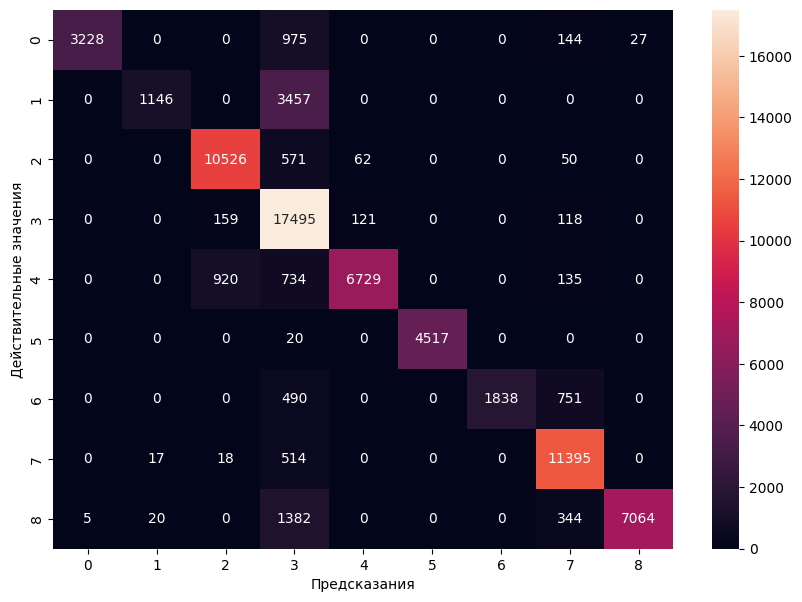

In [56]:
predictions = model.predict(tf_test)

plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(label_test, predictions), annot=True, fmt='d')
plt.xlabel('Предсказания')
plt.ylabel('Действительные значения')
plt.show()